# **EDA Metadata**

**Course:** Master in Big Data, Data Science & AI — Master Thesis  
**Author:** Carlota Trigo La Blanca  

*This notebook will be used to do the exploratory data analysis of the metadata extracted from the database developed for my Master Thesis.
Only the metadata values that came with the datasets \(gender, age, body region, lesion type and diagnosis\).*


**Table of Contents**

- [Initialization](#Initialization)
- [Load Dataset](#Load-Dataset)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Age](#Age)
    - [Body region](#Body-region)
    - [Gender](#Sex)
    - [Lesion](#Lesion)
    - [Diagnosis](#Diagnosis)

## **Initialization**

In [2]:
# 1) Install GCS connector
!pip install -q gcsfs

# 2) Auth to your Google account
from google.colab import auth
auth.authenticate_user()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Load Dataset**

In [4]:
df = pd.read_csv('gs://ucm_tfm_datos_carlotatrigo/metadata.csv')
df.head()

,image_id,origin_dataset,lesion_type,diagnosis,body_region,age,gender
0,ISIC_0000000.jpg,ISIC2019,benign,NV,anterior torso,55,female
1,ISIC_0000001.jpg,ISIC2019,benign,NV,anterior torso,30,female
2,ISIC_0000002.jpg,ISIC2019,malignant,MEL,upper extremity,60,female
3,ISIC_0000003.jpg,ISIC2019,benign,NV,upper extremity,30,male
4,ISIC_0000004.jpg,ISIC2019,malignant,MEL,posterior torso,80,male


In [5]:
df.shape

(71715, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71715 entries, 0 to 71714
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_id        71715 non-null  object
 1   origin_dataset  71715 non-null  object
 2   lesion_type     71715 non-null  object
 3   diagnosis       71715 non-null  object
 4   body_region     71715 non-null  object
 5   age             71715 non-null  object
 6   gender          71715 non-null  object
dtypes: object(7)
memory usage: 3.8+ MB


In [7]:
len(df['image_id'].unique()), len(df) # checking that I only have unique image identifiers

(71715, 71715)

In [8]:
# As expected, there are no NaNs. They are corrected during the database creation step.
df.isna().sum()

,0
image_id,0
origin_dataset,0
lesion_type,0
diagnosis,0
body_region,0
age,0
gender,0


## **Exploratory Data Analysis**

### Age

In [9]:
df['age'] = pd.to_numeric(df['age'], errors='coerce')

df['age'] = df['age'].replace('not_provided', np.nan)
# df['age'] = df['age'].replace(np.nan, 'not_provided')
# df['age'] = df['age'].replace('Unknown', 'not_provided')

In [10]:
df['age'].describe()

,age
count,70872.000000
mean,52.613924
std,16.536828
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,90.000000


In [11]:
df['age'].replace(np.nan, 'not_provided').value_counts().sort_values(ascending = False)

,count
age,
50.0,7902
45.0,7779
55.0,7112
60.0,6528
40.0,6321
65.0,6198
70.0,5610
35.0,4800
75.0,4086


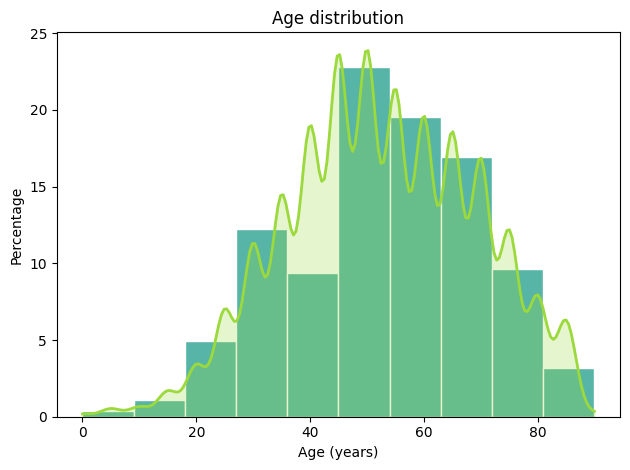

In [12]:
# Clean ages
age = pd.to_numeric(df['age'], errors='coerce').dropna()
age = age[(age >= 0) & (age <= 120)]

# Colors from viridis
c_hist = plt.cm.viridis(0.55)
c_kde  = plt.cm.viridis(0.85)

plt.figure()
ax = sns.histplot(age, stat='percent', bins=10, kde=True,
                  color=c_hist, edgecolor='white', alpha=0.75)

# Shade the KDE
if ax.lines:
    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    ax.lines[0].set_color(c_kde)
    ax.lines[0].set_linewidth(2)
    ax.fill_between(x, y, color=c_kde, alpha=0.25)

ax.set_title('Age distribution')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Percentage')
plt.tight_layout()
plt.show()

In [13]:
df['age'] = df['age'].replace(np.nan, 'not_provided')

### Body region

In [14]:
df['body_region'].unique()

array(['anterior torso', 'upper extremity', 'posterior torso',
       'lower extremity', 'not_provided', 'lateral torso', 'head/neck',
       'palms/soles', 'trunk', 'chest', 'back', 'abdomen', 'foot', 'face',
       'neck', 'scalp', 'genital', 'hand', 'ear', 'acral',
       'upper_extremity', 'oral/genital', 'torso', 'head_neck_face',
       'lower_extremity', 'left arm - lower', 'right leg - lower',
       'left leg - upper', 'right arm - lower', 'left leg - lower',
       'right arm - upper', 'right leg - upper', 'left arm - upper',
       'right arm', 'left leg', 'left arm', 'right leg'], dtype=object)

In [15]:
loc_map = {
    # trunk
    'anterior torso':'trunk','posterior torso':'trunk','lateral torso':'trunk',
    'trunk':'trunk','torso':'trunk','chest':'trunk','back':'trunk','abdomen':'trunk',

    # upper extremity
    'upper extremity':'upper_extremity','upper_extremity':'upper_extremity',
    'left arm - lower':'upper_extremity','left arm - upper':'upper_extremity',
    'right arm - lower':'upper_extremity','right arm - upper':'upper_extremity',
    'right arm':'upper_extremity','left arm':'upper_extremity',

    # lower extremity
    'lower extremity':'lower_extremity','lower_extremity':'lower_extremity',
    'left leg - lower':'lower_extremity','left leg - upper':'lower_extremity',
    'right leg - lower':'lower_extremity','right leg - upper':'lower_extremity',
    'right leg':'lower_extremity','left leg':'lower_extremity',

    # head/neck/face
    'head/neck':'head_neck_face','head_neck_face':'head_neck_face',
    'face':'head_neck_face','neck':'head_neck_face','scalp':'head_neck_face','ear':'head_neck_face',

    # acral (hands/feet/palms/soles)
    'palms/soles':'acral','hand':'acral','foot':'acral','acral':'acral',

    # mucosal / genital
    'genital':'mucosal_genital','oral/genital':'mucosal_genital',

    # unknown
    'not_provided':'unknown',
}


df['body_region'] = df['body_region'].replace(loc_map)

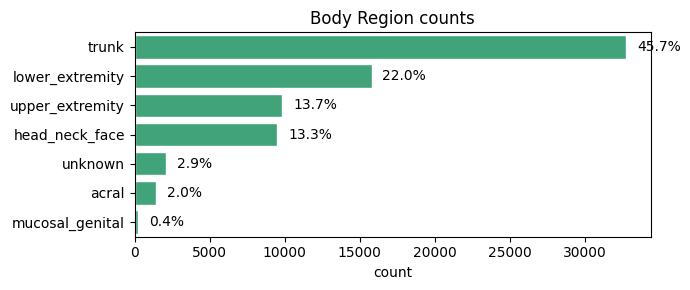

In [16]:
order = df['body_region'].value_counts().index
total = len(df)

plt.figure(figsize=(7, max(3, 0.35*len(order))))
ax = sns.countplot(data=df, y='body_region', order=order,
                   color=plt.cm.viridis(0.65), edgecolor='white')

ax.set_title('Body Region counts')
ax.set_xlabel('count'); ax.set_ylabel('')

# annotate count and % on each bar
for p in ax.patches:
    cnt = int(p.get_width())
    pct = 100 * cnt / total
    ax.text(p.get_width() + max(1, 0.01*total),
            p.get_y() + p.get_height()/2,
            f'{pct:.1f}%',
            va='center')

plt.tight_layout()
plt.show()

### Gender

In [17]:
df['gender'].unique()

array(['female', 'male', 'not_provided'], dtype=object)

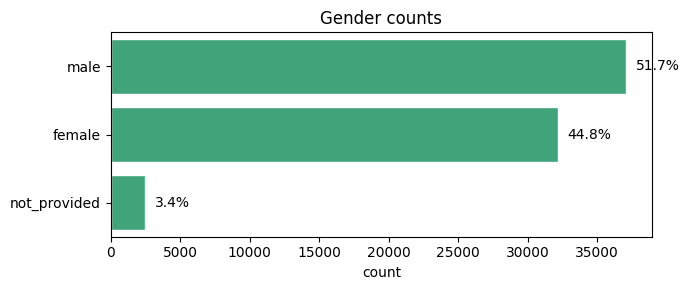

In [18]:
order = df['gender'].value_counts().index
total = len(df)

plt.figure(figsize=(7, max(3, 0.35*len(order))))
ax = sns.countplot(data=df, y='gender', order=order,
                   color=plt.cm.viridis(0.65), edgecolor='white')

ax.set_title('Gender counts')
ax.set_xlabel('count'); ax.set_ylabel('')

# annotate count and % on each bar
for p in ax.patches:
    cnt = int(p.get_width())
    pct = 100 * cnt / total
    ax.text(p.get_width() + max(1, 0.01*total),
            p.get_y() + p.get_height()/2,
            f'{pct:.1f}%',
            va='center')

plt.tight_layout()
plt.show()

### Lesion

In [19]:
df['lesion_type'].unique()

array(['benign', 'malignant', 'no_lesion'], dtype=object)

In [20]:
df['lesion_type'].value_counts()

,count
lesion_type,
benign,52247
malignant,17718
no_lesion,1750


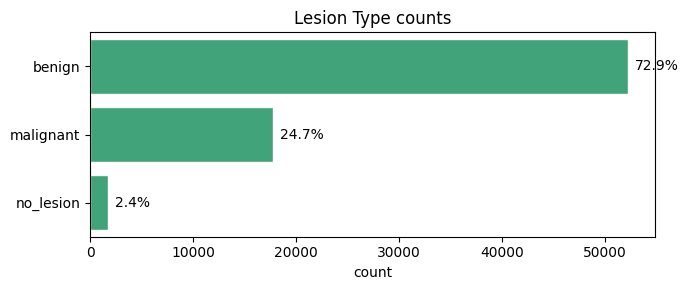

In [21]:
order = df['lesion_type'].value_counts().index
total = len(df)

plt.figure(figsize=(7, max(3, 0.35*len(order))))
ax = sns.countplot(data=df, y='lesion_type', order=order,
                   color=plt.cm.viridis(0.65), edgecolor='white')

ax.set_title('Lesion Type counts')
ax.set_xlabel('count'); ax.set_ylabel('')

# annotate count and % on each bar
for p in ax.patches:
    cnt = int(p.get_width())
    pct = 100 * cnt / total
    ax.text(p.get_width() + max(1, 0.01*total),
            p.get_y() + p.get_height()/2,
            f'{pct:.1f}%',
            va='center')

plt.tight_layout()
plt.show()

### Diagnosis

In [22]:
df['diagnosis'].unique()

array(['NV', 'MEL', 'BKL', 'UNKNOWN', 'DF', 'AKIEC', 'BCC', 'VASC',
       'SCCKA', 'SCC', 'INF', 'BEN_OTH', 'MAL_OTH', 'NO_LESION'],
      dtype=object)

In [23]:
dx_map7 = {
    'NV':'nv', 'MEL':'mel', 'BKL':'bkl', 'BCC':'bcc',
    'AKIEC':'scc_akiec', 'SCC':'scc_akiec', 'SCCKA':'scc_akiec',
    'VASC':'vasc', 'DF':'df',
    'INF':'other_benign', 'BEN_OTH':'other_benign',
    'MAL_OTH':'other_malignant',
    'UNKNOWN':'unknown', 'NO_LESION':'no_lesion'
}

df['diagnosis_grouped'] = df['diagnosis'].map(dx_map7)

In [24]:
vc = df['diagnosis_grouped'].value_counts(dropna=False)
display(pd.DataFrame({"count": vc, "pct": (100*vc/vc.sum()).round(2)}))

,count,pct
diagnosis_grouped,,
unknown,26698,37.23
nv,20468,28.54
bcc,8453,11.79
mel,6165,8.60
bkl,4142,5.78
scc_akiec,3082,4.30
no_lesion,1750,2.44
df,389,0.54
vasc,386,0.54


Count number of occurrences of each of the diagnosis

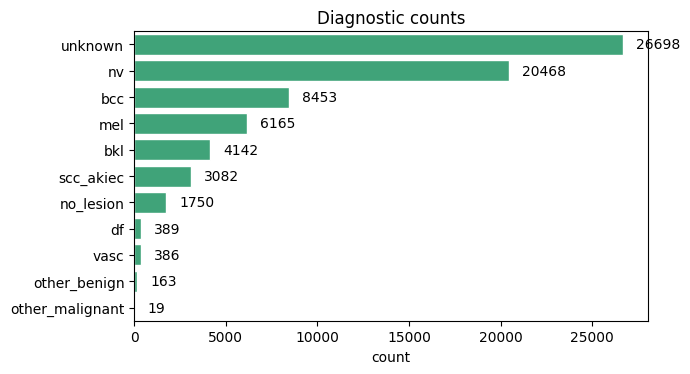

In [25]:
order = df['diagnosis_grouped'].value_counts().index
total = len(df)

plt.figure(figsize=(7, max(3, 0.35*len(order))))
ax = sns.countplot(data=df, y='diagnosis_grouped', order=order,
                   color=plt.cm.viridis(0.65), edgecolor='white')

ax.set_title('Diagnostic counts')
ax.set_xlabel('count'); ax.set_ylabel('')

# annotate count and % on each bar
for p in ax.patches:
    cnt = int(p.get_width())
    pct = 100 * cnt / total
    ax.text(p.get_width() + max(1, 0.01*total),
            p.get_y() + p.get_height()/2,
            f'{cnt}',
            va='center')

plt.tight_layout()
plt.show()

Check where do each of the diagnostic types come from

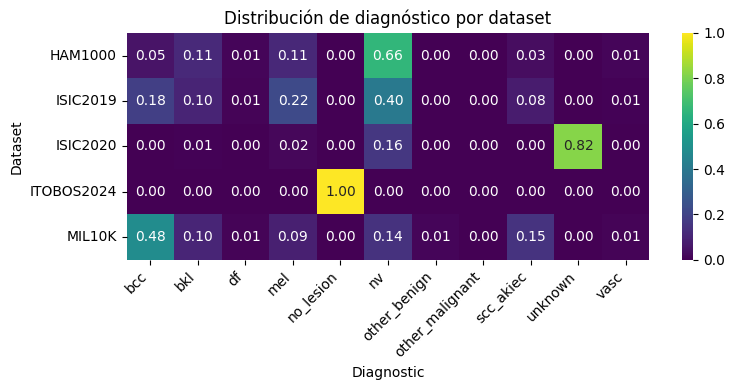

In [26]:
ct = pd.crosstab(df['origin_dataset'], df['diagnosis_grouped'])
ct_norm = ct.div(ct.sum(axis=1), axis=0).round(3)

plt.figure(figsize=(8,4))
sns.heatmap(ct_norm, annot=True, fmt=".2f", cmap = 'viridis')
plt.ylabel('Dataset')
plt.xlabel('Diagnostic')
plt.xticks(rotation = 45, ha = 'right')
plt.title("Distribución de diagnóstico por dataset")
plt.tight_layout()
plt.show()

### Correlation lesion vs diagnosis

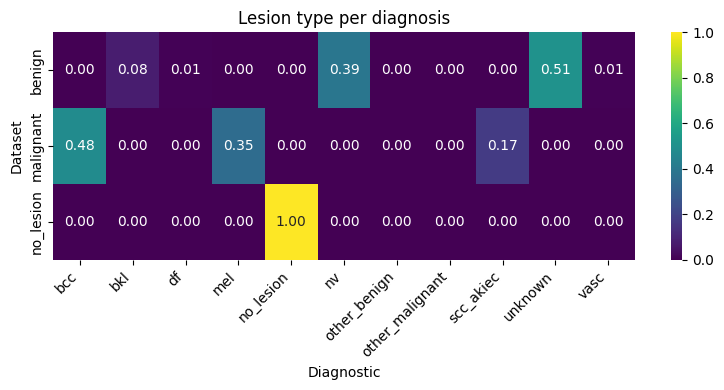

In [27]:
ct = pd.crosstab(df['lesion_type'], df['diagnosis_grouped'])
ct_norm = ct.div(ct.sum(axis=1), axis=0).round(3)

plt.figure(figsize=(8,4))
sns.heatmap(ct_norm, annot=True, fmt=".2f", cmap = 'viridis')
plt.ylabel('Dataset')
plt.xlabel('Diagnostic')
plt.xticks(rotation = 45, ha = 'right')
plt.title("Lesion type per diagnosis")
plt.tight_layout()
plt.show()

In [28]:
ct

diagnosis_grouped,bcc,bkl,df,mel,no_lesion,nv,other_benign,other_malignant,scc_akiec,unknown,vasc
lesion_type,,,,,,,,,,,
benign,0,4142,389,0,0,20468,163,1,0,26698,386
malignant,8453,0,0,6165,0,0,0,18,3082,0,0
no_lesion,0,0,0,0,1750,0,0,0,0,0,0


### Correlation age vs body region


/tmp/ipython-input-3578439932.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['age'] = df['age'].replace('not_provided', np.nan)


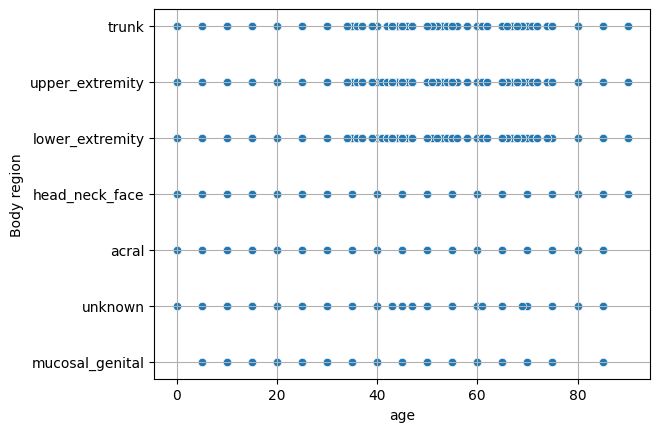

In [58]:
# plt.title('Examining areas of cancer by age')

df2 = df.copy()
df2['age'] = df['age'].replace('not_provided', np.nan)
df2['body_region'] = df['body_region'].replace('not_provided', np.nan)
df2 = df2.dropna(subset=['age', 'body_region'])

sns.scatterplot(data = df2, x = 'age', y = 'body_region') #, palette = 'viridis')
plt.ylabel('Body region')
plt.xlabel('age')
plt.grid()
plt.show()

### Correlation age vs gender

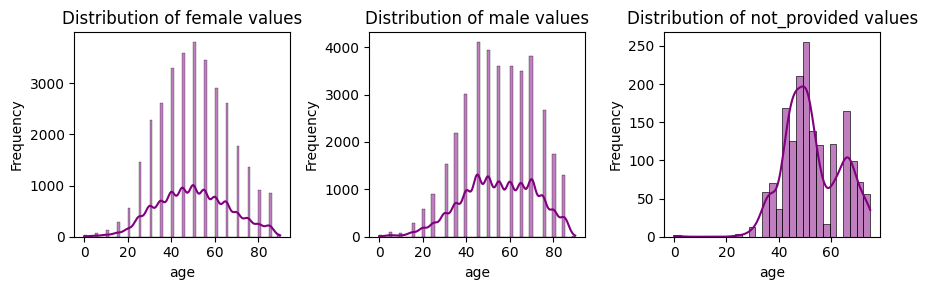

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

for i, gen in enumerate(df2['gender'].unique()):
    sns.histplot(data = df2[df2['gender'] == gen], x = 'age', kde=True, color='purple', ax=axes[i])
    # axes[i].set_xlabel(f'{n3[i]} Values')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of {gen} values')

plt.tight_layout()
plt.show()

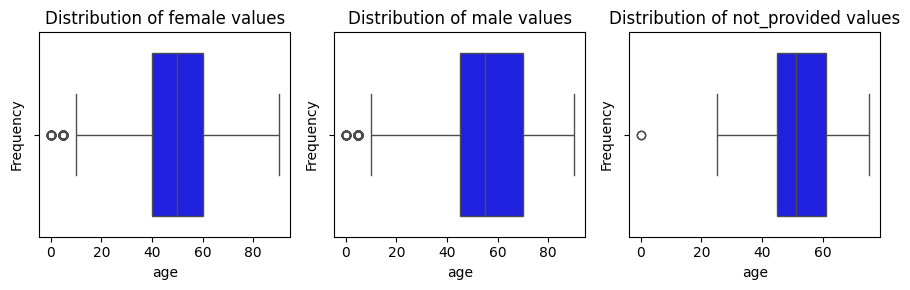

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

for i, gen in enumerate(df2['gender'].unique()):
    sns.boxplot(data = df2[df2['gender'] == gen], x = 'age', color = 'blue', ax=axes[i])
    # axes[i].set_xlabel(f'{n3[i]} Values')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of {gen} values')

plt.tight_layout()
plt.show()

### Correlation gender vs body region

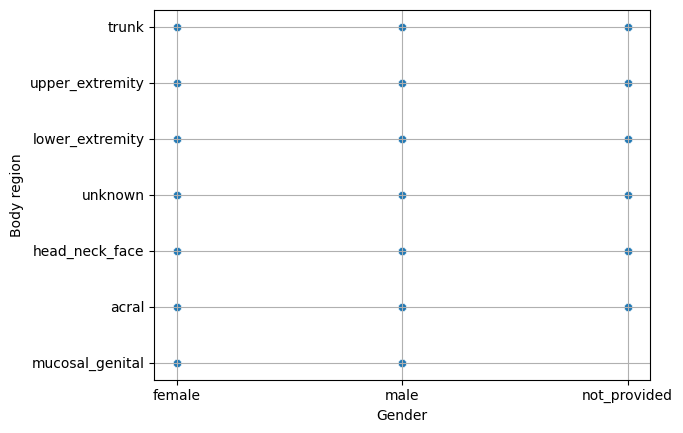

In [41]:
sns.scatterplot(data = df, x = 'gender', y = 'body_region') #, palette = 'viridis')
plt.ylabel('Body region')
plt.xlabel('Gender')
plt.grid()
plt.show()

### Correlation diagnosis vs body region

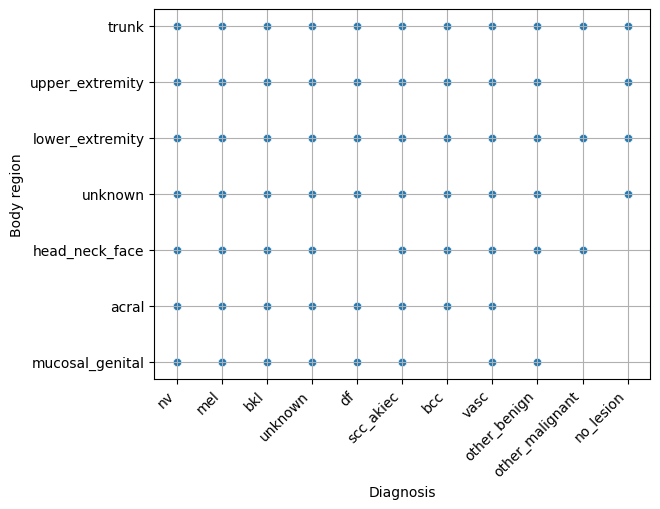

In [53]:
sns.scatterplot(data = df, x = 'diagnosis_grouped', y = 'body_region') #, palette = 'viridis')
plt.ylabel('Body region')
plt.xlabel('Diagnosis')
plt.xticks(rotation = 45, ha = 'right')
plt.grid()
plt.show()

### Save modified metadata file

In [60]:
df.to_csv('gs://ucm_tfm_datos_carlotatrigo/metadata_clean.csv', index = False)